In [62]:
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

In [2]:
df_one = pd.read_csv('../final_news_df.csv')
df_one = df_one[['headline', 'category']]

In [3]:
def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    return df[["short_description", "category"]]

df_two = load_data('../News_Category_Dataset_v2.json')
df_two.head()

,short_description,category
0,She left her husband. He killed their children...,CRIME
1,Of course it has a song.,ENTERTAINMENT
2,The actor and his longtime girlfriend Anna Ebe...,ENTERTAINMENT
3,The actor gives Dems an ass-kicking for not fi...,ENTERTAINMENT
4,"The ""Dietland"" actress said using the bags is ...",ENTERTAINMENT


In [4]:
df_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  30000 non-null  object
 1   category  30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


In [5]:
df_one.category.value_counts()

BUSINESS        5000
POLITICS        5000
WELLNESS        5000
PARENTING       5000
FOOD & DRINK    5000
WORLD NEWS      5000
Name: category, dtype: int64

In [6]:
df_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   short_description  200853 non-null  object  
 1   category           200853 non-null  category
dtypes: category(1), object(1)
memory usage: 1.7+ MB


### DF Two Preparation

In [7]:
df_two.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [8]:
business = df_two[(df_two['category'] == 'BUSINESS') | (df_two['category'] == 'TECH') | (df_two['category'] == 'MONEY')]
food = df_two[(df_two['category'] == 'FOOD & DRINK')]
parenting = df_two[(df_two['category'] == 'PARENTING') | (df_two['category'] == 'PARENTS')]
politics = df_two[(df_two['category'] == 'POLITICS')]
wellness = df_two[(df_two['category'] == 'WELLNESS')]
world_news = df_two[(df_two['category'] == 'THE WORLDPOST') | (df_two['category'] == 'WORLDPOST') | (df_two['category'] == 'WORLD NEWS')]

In [9]:
business['category'] = 'BUSINESS'
food['category'] = 'FOOD & DRINK'
parenting['category'] = 'PARENTING'
politics['category'] = 'POLITICS'
wellness['category'] = 'WELLNESS'
world_news['category'] = 'WORLD NEWS'

C:\Users\patri\AppData\Local\Temp/ipykernel_16196/1727108867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business['category'] = 'BUSINESS'
C:\Users\patri\AppData\Local\Temp/ipykernel_16196/1727108867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food['category'] = 'FOOD & DRINK'
C:\Users\patri\AppData\Local\Temp/ipykernel_16196/1727108867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [10]:
final_df_two = business.append([food, parenting, politics, wellness, world_news])

In [11]:
final_df_two.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87570 entries, 87 to 124973
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  87570 non-null  object
 1   category           87570 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [12]:
final_df_two.category.value_counts()

POLITICS        32739
WELLNESS        17827
PARENTING       12632
BUSINESS         9726
WORLD NEWS       8420
FOOD & DRINK     6226
Name: category, dtype: int64

In [13]:
final_df_two = final_df_two.rename(columns={"short_description":"headline"})

## Merge

In [14]:
merged_df = df_one.append([final_df_two])

In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117570 entries, 0 to 124973
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   headline  117570 non-null  object
 1   category  117570 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


## Further Preprocessing

In [16]:
le = preprocessing.LabelEncoder()
merged_df['label_encoding'] = le.fit_transform(merged_df['category'])

In [17]:
## Shuffling the dataframe prior to splitting into Train & Test splits

merged_df = merged_df.sample(frac=1).reset_index(drop=True)

In [18]:
X = merged_df['headline']
y = merged_df['label_encoding']

X = X.to_numpy()
y = y.to_numpy()

In [19]:
# Containers defined for later use in tokenizing and padding

training_size = 94056
vocab_size  = 30000
max_length  = 24
embedding_dimensions  = 64
oov_tok  = "<OOV>"

# Train and Test

X_train  = X[0:training_size]
X_test = X[training_size:]
y_train  = y[0:training_size]
y_test = y[training_size:]

## Tokenizing & Padding

In [20]:
# Tokenizing
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n123456789")
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

#Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(training_sequences, padding='post', truncating='post')
X_test_padded = pad_sequences(testing_sequences, padding='post', truncating='post')

In [21]:
X_train_padded[5]

array([   19,    17,   541,     2,  2186,     9,  4282,  8266,     8,
       14727,    14,   436,  1811,    17,    32,   468,   144,   445,
          17,    32,   468,     4,   144,   235, 16461,     6,   851,
          28,  7927,    62,     8,     2, 29603,  1430,    49,  3559,
          56,     5,  3405,    40,  2613,   519,    18,   261,   152,
         701,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [22]:
## Addressing class imbalance

oversample = SMOTE()
X_train_padded_smoted, y_train_smoted = oversample.fit_resample(X_train_padded, y_train)

In [23]:
## Making y categorical to prepare for modelling

num_classes = np.max(y_train) + 1
y_train_smoted = utils.to_categorical(y_train_smoted, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [152]:
y_train_smoted

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## Model

In [24]:
#tf.config.run_functions_eagerly(True)

In [112]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dimensions, embeddings_initializer="uniform",))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(20, activation='relu'))
#model.add(layers.Dense(300, activation='relu'))
#model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.2))
#model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1920000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 400)               26000     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_7 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [105]:
## Setting a callback to stop training when the validation accuracy has not increased in the past 4 epochs

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, verbose=1, min_delta=0.001, mode='min')

In [113]:
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_padded_smoted,
                    y_train_smoted,
                    epochs=10,
                    validation_data=(X_test_padded, y_test),
                    batch_size=200,
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                    verbose=1)

Epoch 1/10
907/907 [==============================] - 6s 6ms/step - loss: 1.7363 - accuracy: 0.2314 - val_loss: 1.5856 - val_accuracy: 0.4037
Epoch 2/10
907/907 [==============================] - 5s 6ms/step - loss: 1.6059 - accuracy: 0.3125 - val_loss: 1.3624 - val_accuracy: 0.4583
Epoch 3/10
907/907 [==============================] - 5s 6ms/step - loss: 1.5316 - accuracy: 0.3615 - val_loss: 1.3126 - val_accuracy: 0.5129
Epoch 4/10
907/907 [==============================] - 5s 6ms/step - loss: 1.4866 - accuracy: 0.3949 - val_loss: 1.2213 - val_accuracy: 0.5586
Epoch 5/10
907/907 [==============================] - 5s 6ms/step - loss: 1.4468 - accuracy: 0.4203 - val_loss: 1.1734 - val_accuracy: 0.5791
Epoch 6/10
907/907 [==============================] - 5s 6ms/step - loss: 1.4116 - accuracy: 0.4414 - val_loss: 1.1717 - val_accuracy: 0.5926
Epoch 7/10
907/907 [==============================] - 5s 6ms/step - loss: 1.3825 - accuracy: 0.4560 - val_loss: 1.1142 - val_accuracy: 0.6219
Epoch 

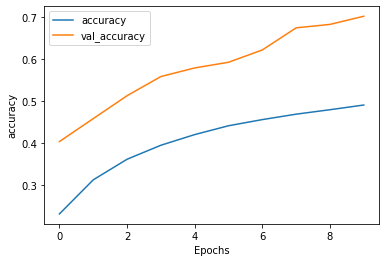

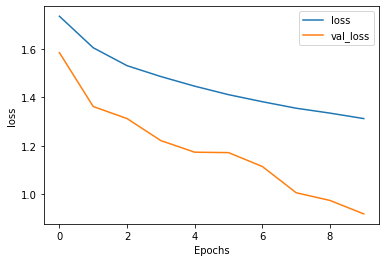

In [114]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [115]:
model.save('./headline_model',save_format='tf')

INFO:tensorflow:Assets written to: ./headline_model\assets


## Model Testing

In [148]:
test_headline = "Families moving abroad more often"

sequences = tokenizer.texts_to_sequences(test_headline)
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
test_preds = model.predict(padded)

In [149]:
test_preds

array([[4.73062135e-02, 8.24494194e-03, 2.91600954e-02, 8.87662649e-01,
        1.45453280e-02, 1.30807748e-02],
       [2.63651460e-02, 1.62419248e-02, 3.60452868e-02, 8.98519158e-01,
        1.34026632e-02, 9.42587852e-03],
       [3.80470514e-01, 2.67591868e-02, 5.86130656e-02, 7.18019810e-03,
        3.97929877e-01, 1.29047126e-01],
       [5.77271804e-02, 6.27797395e-02, 6.04634106e-01, 9.94521845e-03,
        2.33618617e-01, 3.12951580e-02],
       [5.69053367e-02, 1.13832513e-02, 1.13548553e-02, 7.20465660e-01,
        2.55441363e-03, 1.97336555e-01],
       [5.77271804e-02, 6.27797395e-02, 6.04634106e-01, 9.94521845e-03,
        2.33618617e-01, 3.12951580e-02],
       [2.31264889e-01, 8.53083134e-02, 1.83002457e-01, 3.02421977e-03,
        4.02808666e-01, 9.45915058e-02],
       [2.89515346e-01, 1.13809206e-01, 1.25878900e-01, 1.12154491e-01,
        6.03325106e-02, 2.98309505e-01],
       [1.30094945e-01, 1.65744379e-01, 1.12851314e-01, 3.64400655e-01,
        3.93216386e-02, 

In [150]:
# Generate arg maxes for predictions
classes = np.argmax(test_preds, axis = 1)
print(classes)

[3 3 4 2 3 2 4 5 3 4 1 3 2 5 5 3 3 4 3 1 3 3 3 4 1 3 4 3 1 3 2 4 5]


In [151]:
## Looking at all the predicted categories assigned to each word, which is the most frequent category?
print(np.bincount(classes).argmax())

3


In [121]:
def classify_headline(target):
    
    sequences = tokenizer.texts_to_sequences(target)
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    preds = model.predict(padded)
    
    classes = np.argmax(preds, axis = 1)
    dominant_class = np.bincount(classes).argmax()
    
    if dominant_class == 0:
        prediction = 'Business'
    elif dominant_class == 1:
        prediction = 'Food & Drink'
    elif dominant_class == 2:
        prediction = 'Parenting'
    elif dominant_class == 3:
        prediction = 'Politics'
    elif dominant_class == 4:
        prediction = 'Wellness'
    elif dominant_class == 5:
        prediction = 'World News'
    
    return prediction

In [122]:
classify_headline("The US passes new law for international governments")

'Politics'

In [123]:
classify_headline("New dinner recipes with healthy food")

'Politics'

In [140]:
classify_headline("children")

'Politics'